In [ ]:
!pip install -q pyvi scikit-learn transformers torch accelerate seaborn tqdm

import itertools
import json
import os
import gc
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, TrainingArguments, Trainer
from pyvi import ViTokenizer
import shutil
import datetime

if torch.cuda.device_count() > 1:
    print(f"Running on Multi-GPU: {torch.cuda.device_count()} devices")
    BATCH_SIZE = 32
else:
    print("Running on Single GPU or CPU")
    BATCH_SIZE = 16

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seed
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(42)


IGNORED_LABELS = {'PER_VICTIMPACT', 'CAUSES', 'CONSEQUENCES'}
VALID_SCHEMA = {
    'LOCATED_AT': [('EVENT', 'LOC')],
    'HAPPENED_ON': [('EVENT', 'TIME')],
    'INVOLVED': [('EVENT', 'VEH'), ('PER_DRIVER', 'VEH'), ('PER_VICTIM', 'VEH')],
    'CAUSED_BY': [('EVENT', 'CAUSE')],
    'HAS_CONSEQUENCE': [('EVENT', 'CONSEQUENCE')]
}

def is_valid_relation(label, s_type, o_type):
    if label in IGNORED_LABELS: return False
    if label not in VALID_SCHEMA: return False
    return (s_type, o_type) in VALID_SCHEMA[label]

Running on Single GPU or CPU


# 2. LOAD RAW DATA & SPLIT DATA

In [ ]:

DATA_PATH = '/kaggle/input/nlp-data-test/new_output.json'

# --- 1. CẤU HÌNH SCHEMA ---
# Đảm bảo tên nhãn khớp với JSON
VALID_SCHEMA = {
    'LOCATED_AT':      [('EVENT', 'LOC')], 
    'HAPPENED_ON':     [('EVENT', 'TIME')],
    'INVOLVED':        [('EVENT', 'VEH'),  ('PER_DRIVER', 'VEH'), ('PER_VICTIM', 'VEH')],
    'CAUSED_BY':       [('EVENT', 'CAUSE')], 
    'HAS_CONSEQUENCE': [('EVENT', 'CONSEQUENCE')]
}

ALLOWED_TYPE_PAIRS = set()
for rel, pairs in VALID_SCHEMA.items():
    for p in pairs: ALLOWED_TYPE_PAIRS.add(p)

print(f" Schema Filter: {len(ALLOWED_TYPE_PAIRS)} cặp hợp lệ.")
print(" Đã loại bỏ hoàn toàn: PER_VICTIMPACT, CAUSES, CONSEQUENCES.")

# --- 2. HÀM CHÈN THẺ TYPED MARKERS ---
def process_text_typed(text, e1, e2):
    try:
        l1 = e1['label'] 
        l2 = e2['label'] 
        
        tag1_open, tag1_close = f" <S:{l1}> ", f" </S:{l1}> "
        tag2_open, tag2_close = f" <O:{l2}> ", f" </O:{l2}> "
        
        spans = [
            (int(e1['start']), tag1_open), (int(e1['end']), tag1_close),
            (int(e2['start']), tag2_open), (int(e2['end']), tag2_close)
        ]
        spans.sort(key=lambda x: x[0], reverse=True)
        
        processed_text = text
        for idx, token in spans:
            processed_text = processed_text[:idx] + token + processed_text[idx:]
            
        return ViTokenizer.tokenize(processed_text)
    except Exception as e:
        return ""

def load_data(path):
    if not os.path.exists(path): return [], set()
    with open(path, 'r', encoding='utf-8') as f: data = json.load(f)
    
    samples = []
    found_labels = set()
    
    for task in data:
        text = task.get('data', {}).get('text') or task.get('text')
        if not text: continue
        
        annotations = task.get('annotations', [])
        if not annotations: continue
        res = annotations[0].get('result', [])
        
        ents, rels = {}, {}
        
        # A. Trích xuất Entity & Label
        for i in res:
            if i['type'] == 'labels':
                if 'id' not in i: continue 
                
                eid = i['id']
                val = i['value']
                
                if 'labels' in val and len(val['labels']) > 0:
                    lbl = val['labels'][0]
                    
                    # Nếu nhãn nằm trong danh sách đen thì bỏ qua luôn từ đầu
                    if lbl in ['PER_VICTIMPACT', 'CAUSES', 'CONSEQUENCES']:
                        continue

                    found_labels.add(lbl)
                    ents[eid] = {
                        'start': val['start'], 
                        'end': val['end'], 
                        'label': lbl
                    }
                    
            elif i['type'] == 'relation':
                if 'labels' in i and len(i['labels']) > 0:
                    rels[(i['from_id'], i['to_id'])] = i['labels'][0]
        
        # B. Duyệt cặp tạo data
        ent_ids = list(ents.keys())
        for e1_id in ent_ids:
            for e2_id in ent_ids:
                if e1_id == e2_id: continue
                
                e1, e2 = ents[e1_id], ents[e2_id]
                
                # Filter theo Schema (Bước này sẽ chặn triệt để)
                if (e1['label'], e2['label']) not in ALLOWED_TYPE_PAIRS:
                    continue
                
                # Lấy nhãn quan hệ
                label = rels.get((e1_id, e2_id), "NO_RELATION")
                if 'IGNORED_LABELS' in globals() and label in IGNORED_LABELS: continue
                
                # Xử lý text
                processed = process_text_typed(text, e1, e2)
                if processed:
                    samples.append({'text': processed, 'label': label})
                    
    return samples, found_labels


print("Đang xử lý dữ liệu với Typed Markers...")
raw_data, all_entity_types = load_data(DATA_PATH)

if len(raw_data) == 0:
    print(" LỖI: Không tìm thấy mẫu dữ liệu nào sau khi lọc!")
else:
    print(f" Tổng số mẫu: {len(raw_data)}")
    print(f" Các loại thực thể được giữ lại: {all_entity_types}")

    # Tạo SPECIAL_TOKENS
    SPECIAL_TOKENS = []
    for lbl in all_entity_types:
        SPECIAL_TOKENS.extend([f"<S:{lbl}>", f"</S:{lbl}>", f"<O:{lbl}>", f"</O:{lbl}>"])

    print(f" Đã tạo {len(SPECIAL_TOKENS)} tokens đặc biệt.")

    # Tạo Label Mapping
    label2id = {l: i for i, l in enumerate(sorted(list(set([x['label'] for x in raw_data]))))}
    if "NO_RELATION" in label2id:
        all_lbl = sorted(list(label2id.keys()))
        all_lbl.remove("NO_RELATION")
        all_lbl.insert(0, "NO_RELATION")
        label2id = {l: i for i, l in enumerate(all_lbl)}
        
    id2label = {i: l for l, i in label2id.items()} 


    try:
        train_data, test_data = train_test_split(raw_data, test_size=0.2, stratify=[x['label'] for x in raw_data], random_state=42)
        print(f" Train set: {len(train_data)} | Test set: {len(test_data)}")
    except ValueError as e:
        print(f" Lỗi chia dữ liệu: {e}")
        train_data, test_data = train_test_split(raw_data, test_size=0.2, random_state=42)
        print(f" (Fallback) Train set: {len(train_data)} | Test set: {len(test_data)}")

 Schema Filter: 7 cặp hợp lệ.
 Đã loại bỏ hoàn toàn: PER_VICTIMPACT, CAUSES, CONSEQUENCES.
Đang xử lý dữ liệu với Typed Markers...
 Tổng số mẫu: 25491
 Các loại thực thể được giữ lại: {'TIME', 'CAUSE', 'PER_VICTIM', 'LOC', 'CONSEQUENCE', 'EVENT', 'ORG', 'VEH', 'PER_DRIVER'}
 Đã tạo 36 tokens đặc biệt.
 Train set: 20392 | Test set: 5099


# 3. FEATURE EXTRACTION FOR ML (PHOBERT FROZEN)

In [ ]:
print("\n--- Đang trích xuất đặc trưng (Vector hóa) cho ML ---")
# 1. SETUP TOKENIZER & MODEL
# Lưu ý: SPECIAL_TOKENS phải được lấy từ Cell 2 (bạn đã chạy trước đó)
if 'SPECIAL_TOKENS' not in globals():
    raise ValueError(" Lỗi: Biến SPECIAL_TOKENS chưa tồn tại. Hãy chạy lại Cell 2 trước!")

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
tokenizer.add_special_tokens({'additional_special_tokens': SPECIAL_TOKENS})

# Dùng tên biến base_model thống nhất từ đầu đến cuối
base_model = AutoModel.from_pretrained("vinai/phobert-base")
base_model.resize_token_embeddings(len(tokenizer)) 

if torch.cuda.device_count() > 1:
    print(f" Sử dụng {torch.cuda.device_count()} GPUs!")
    base_model = nn.DataParallel(base_model)

base_model.to(device).eval()
print(f" Tokenizer & Model đã cập nhật. Vocab size mới: {len(tokenizer)}")

# 2. HÀM TRÍCH XUẤT VECTOR
def extract_vectors(dataset, batch_size=32):
    texts = [item['text'] for item in dataset]
    # Lấy nhãn từ label2id đã tạo ở Cell 2
    labels = [label2id[item['label']] for item in dataset]
    all_vecs = []
    
    # Tắt thanh progress bar nếu in ra quá nhiều dòng
    for i in tqdm(range(0, len(texts), batch_size), desc="Vectorizing"):
        batch_text = texts[i:i+batch_size]
        
        with torch.no_grad():
            # Tokenize batch
            inputs = tokenizer(batch_text, padding=True, truncation=True, max_length=256, return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = base_model(**inputs)
            
            # --- Mean Pooling ---
            # Lấy vector đại diện cho cả câu dựa trên attention mask
            mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
            sum_emb = torch.sum(outputs.last_hidden_state * mask, 1)
            sum_mask = torch.clamp(mask.sum(1), min=1e-9)
            mean_emb = sum_emb / sum_mask
            
            all_vecs.append(mean_emb.cpu().numpy())
            
    return np.vstack(all_vecs), np.array(labels)

# 3. THỰC HIỆN
print(f"--> Xử lý tập Train ({len(train_data)} mẫu):")
X_train_ml, y_train_ml = extract_vectors(train_data)

print(f"--> Xử lý tập Test ({len(test_data)} mẫu):")
X_test_ml, y_test_ml = extract_vectors(test_data)

print(f" Hoàn tất! Kích thước Vector Train: {X_train_ml.shape}")

del base_model
torch.cuda.empty_cache()
gc.collect()


--- Đang trích xuất đặc trưng (Vector hóa) cho ML ---
 Tokenizer & Model đã cập nhật. Vocab size mới: 64037
--> Xử lý tập Train (20392 mẫu):


Vectorizing: 100%|██████████| 638/638 [02:33<00:00,  4.15it/s]


--> Xử lý tập Test (5099 mẫu):


Vectorizing: 100%|██████████| 160/160 [00:38<00:00,  4.18it/s]


 Hoàn tất! Kích thước Vector Train: (20392, 768)


132412

# 4. TRAIN MACHINE LEARNING MODELS

In [25]:
print("\n--- Training ML Models ---")
final_stats = []

# 1. SVM
print("\n=== 1. SUPPORT VECTOR MACHINE (SVM) ===")
svm = LinearSVC(dual=False, max_iter=2000)
svm.fit(X_train_ml, y_train_ml)
y_pred_svm = svm.predict(X_test_ml)

acc_svm = accuracy_score(y_test_ml, y_pred_svm)
f1_svm = f1_score(y_test_ml, y_pred_svm, average='macro')
final_stats.append({"Model": "SVM", "Accuracy": acc_svm, "F1-Macro": f1_svm})
print(f"SVM: Acc={acc_svm:.4f}, F1={f1_svm:.4f}")

# 2. Random Forest
print("\n=== 2. RANDOM FOREST ===")
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(X_train_ml, y_train_ml)
y_pred_rf = rf.predict(X_test_ml)

acc_rf = accuracy_score(y_test_ml, y_pred_rf)
f1_rf = f1_score(y_test_ml, y_pred_rf, average='macro')
final_stats.append({"Model": "RandomForest", "Accuracy": acc_rf, "F1-Macro": f1_rf})
print(f"RandomForest: Acc={acc_rf:.4f}, F1={f1_rf:.4f}")

# 3. Logistic Regression
print("\n=== 3. LOGISTIC REGRESSION ===")
lr = LogisticRegression(max_iter=200, n_jobs=-1)
lr.fit(X_train_ml, y_train_ml)
y_pred_lr = lr.predict(X_test_ml)

acc_lr = accuracy_score(y_test_ml, y_pred_lr)
f1_lr = f1_score(y_test_ml, y_pred_lr, average='macro')
final_stats.append({"Model": "LogisticRegression", "Accuracy": acc_lr, "F1-Macro": f1_lr})
print(f"LogisticRegression: Acc={acc_lr:.4f}, F1={f1_lr:.4f}")


--- Training ML Models ---

=== 1. SUPPORT VECTOR MACHINE (SVM) ===
SVM: Acc=0.8025, F1=0.6569

=== 2. RANDOM FOREST ===
RandomForest: Acc=0.7294, F1=0.3543

=== 3. LOGISTIC REGRESSION ===
LogisticRegression: Acc=0.7782, F1=0.6123


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# 5. PHOBERT FINE-TUNING 

In [ ]:
print("\n=== 5. PHOBERT FINE-TUNING ===")

# --- 1. KIỂM TRA & KHÔI PHỤC BIẾN (FIX LỖI) ---
if 'final_stats' not in globals():
    final_stats = []

if 'SPECIAL_TOKENS' not in globals():
    raise ValueError(" Lỗi: Biến 'SPECIAL_TOKENS' chưa có. Hãy chạy lại Cell 2!")

if 'label2id' not in globals():
    raise ValueError(" Lỗi: Biến 'label2id' chưa có. Hãy chạy lại Cell 2!")

all_labels = list(label2id.keys())
print(f" Đã khôi phục danh sách nhãn: {len(all_labels)} nhãn.")
print(f"   (Chi tiết: {all_labels})")

output_dir = './phobert_finetuned'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

# --- 2. DATASET ---
class REDataset(torch.utils.data.Dataset):
    def __init__(self, data_list, tokenizer):
        self.texts = [x['text'] for x in data_list]
        self.labels = [label2id[x['label']] for x in data_list]
        self.tokenizer = tokenizer
        
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, padding="max_length", max_length=256, return_tensors='pt')
        return {
            'input_ids': enc['input_ids'].flatten(),
            'attention_mask': enc['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
    def __len__(self): return len(self.texts)

# --- 3. SETUP MODEL & TOKENIZER ---
print("--> Khởi tạo Tokenizer & Model...")
phobert_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
phobert_tokenizer.add_special_tokens({'additional_special_tokens': SPECIAL_TOKENS})

# Load Model với số lượng nhãn chính xác
model_finetune = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels=len(all_labels))
model_finetune.resize_token_embeddings(len(phobert_tokenizer))
model_finetune.to(device)

# Tạo Dataset
train_ds = REDataset(train_data, phobert_tokenizer)
test_ds = REDataset(test_data, phobert_tokenizer)

# --- 4. TRAINING ARGUMENTS ---
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=20, 
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    weight_decay=0.01,
    save_total_limit=1,       
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none"
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1_macro': f1_score(p.label_ids, preds, average='macro')
    }

trainer = Trainer(
    model=model_finetune,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

# --- 5. START TRAINING ---
print(" Bắt đầu huấn luyện PhoBERT...")
trainer.train()

# --- 6. EVALUATE ---
eval_res = trainer.evaluate()


final_stats = [x for x in final_stats if "PhoBERT" not in x['Model']]
final_stats.append({
    "Model": "PhoBERT (Fine-tuned)", 
    "Accuracy": eval_res['eval_accuracy'], 
    "F1-Macro": eval_res['eval_f1_macro']
})

print(f"\n KẾT QUẢ CUỐI CÙNG: Acc={eval_res['eval_accuracy']:.4f}, F1={eval_res['eval_f1_macro']:.4f}")

torch.cuda.empty_cache()
gc.collect()


=== 5. PHOBERT FINE-TUNING ===
 Đã khôi phục danh sách nhãn: 6 nhãn.
   (Chi tiết: ['NO_RELATION', 'CAUSED_BY', 'HAPPENED_ON', 'HAS_CONSEQUENCE', 'INVOLVED', 'LOCATED_AT'])
--> Khởi tạo Tokenizer & Model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Bắt đầu huấn luyện PhoBERT...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.432200,0.417799,0.848794,0.797754
2,0.308800,0.315036,0.879976,0.816315
3,0.249200,0.329564,0.883114,0.836771
4,0.208200,0.363562,0.897823,0.847462
5,0.163700,0.352659,0.896450,0.851355
6,0.142700,0.428755,0.898608,0.855377
7,0.119000,0.479506,0.901745,0.858886
8,0.091500,0.541937,0.902922,0.863370
9,0.078700,0.583084,0.903314,0.860513
10,0.064000,0.592599,0.901942,0.859661



 KẾT QUẢ CUỐI CÙNG: Acc=0.9029, F1=0.8634


937

# 6. FINAL COMPARISON (ACCURACY vs F1-SCORE)


=== FINAL LEADERBOARD ===


,Model,Accuracy,F1-Macro
0,SVM,0.802510,0.656924
1,RandomForest,0.729359,0.354272
2,LogisticRegression,0.778192,0.612261
3,PhoBERT (Fine-tuned),0.902922,0.863370


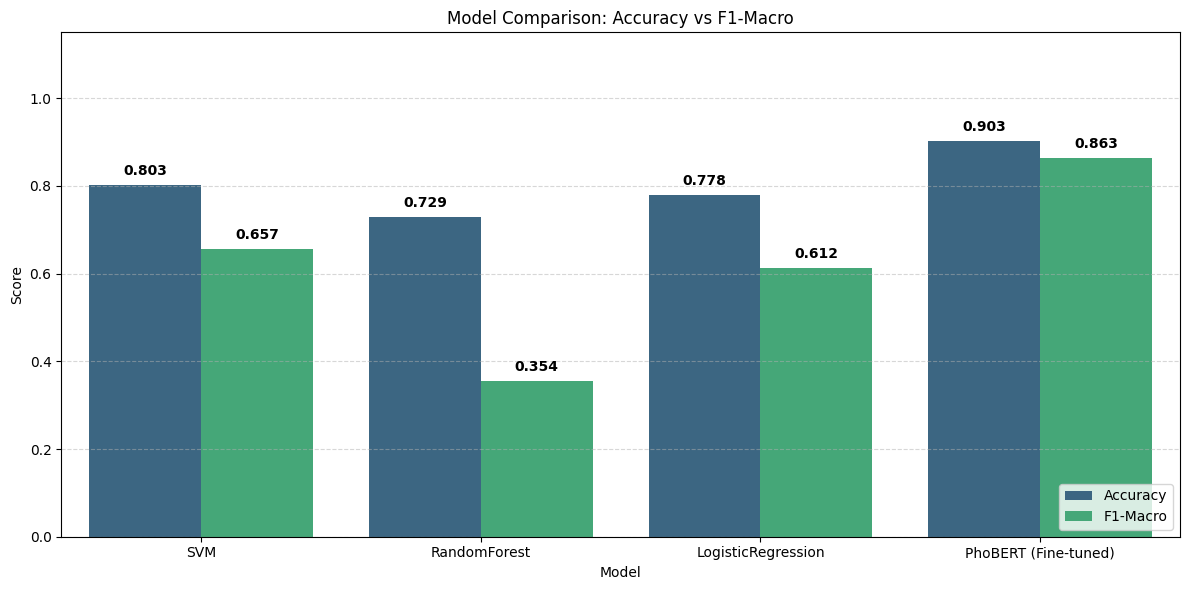

Saved PhoBERT Model.


In [28]:
print("\n=== FINAL LEADERBOARD ===")
df_res = pd.DataFrame(final_stats)

display(df_res)

df_melt = df_res.melt(id_vars="Model", var_name="Metric", value_name="Score")
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_melt, palette="viridis")

plt.title("Model Comparison: Accuracy vs F1-Macro")
plt.ylim(0, 1.15) 
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')


for p in ax.patches:
    if p.get_height() > 0: 
        ax.annotate(f"{p.get_height():.3f}", 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='bold', xytext=(0, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

trainer.save_model("final_models/phobert_finetuned")
phobert_tokenizer.save_pretrained("final_models/phobert_finetuned")
print("Saved PhoBERT Model.")

# 7. DEMO PREDICTION & VISUALIZATION

In [ ]:

input_text = "Tại ngã tư cầu giấy Hà Nội, chiếc xe máy do anh A điều khiển đang chở vợ đã va chạm mạnh với xe tải đi ngược chiều vào 14h30 chiều ngày 22/12, vụ tai nạn khiến anh A bị thương, xe ô tải móp đầu."

subject_text = "vụ tai nạn" 
subject_type = "EVENT"     

object_text  = "bị thương"
object_type  = "CONSEQUENCE" 

print(f" Câu gốc: \"{input_text}\"")
print(f" Kiểm tra quan hệ: [{subject_text} ({subject_type})] -> [{object_text} ({object_type})]")
print("-" * 60)


def prepare_input_typed(text, sub, sub_type, obj, obj_type):
    sub_start = text.find(sub)
    obj_start = text.find(obj)
    
    if sub_start == -1 or obj_start == -1:
        return None, " Không tìm thấy text thực thể trong câu."
    
    sub_end = sub_start + len(sub)
    obj_end = obj_start + len(obj)
    
    # Tạo thẻ Typed Markers
    # <S:TYPE> ... </S:TYPE> và <O:TYPE> ... </O:TYPE>
    tag1_open  = f" <S:{sub_type}> "
    tag1_close = f" </S:{sub_type}> "
    tag2_open  = f" <O:{obj_type}> "
    tag2_close = f" </O:{obj_type}> "
    
    spans = [(sub_start, tag1_open), (sub_end, tag1_close),
             (obj_start, tag2_open), (obj_end, tag2_close)]
    
    spans.sort(key=lambda x: x[0], reverse=True)
    
    processed_text = text
    for idx, token in spans:
        processed_text = processed_text[:idx] + token + processed_text[idx:]
        
    return ViTokenizer.tokenize(processed_text), None


print(" Đang khởi tạo lại Base PhoBERT để lấy vector cho ML...")
ml_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
ml_tokenizer.add_special_tokens({'additional_special_tokens': SPECIAL_TOKENS}) 

ml_base_model = AutoModel.from_pretrained("vinai/phobert-base")
ml_base_model.resize_token_embeddings(len(ml_tokenizer))
ml_base_model.to(device).eval()

def get_embedding_for_ml(processed_text):
    with torch.no_grad():
        inputs = ml_tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = ml_base_model(**inputs)
        
        # Mean Pooling
        mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_emb = torch.sum(outputs.last_hidden_state * mask, 1)
        sum_mask = torch.clamp(mask.sum(1), min=1e-9)
        mean_emb = sum_emb / sum_mask
        
    return mean_emb.cpu().numpy()


# A. BƯỚC GÁC CỔNG (GATEKEEPER)
if (subject_type, object_type) not in ALLOWED_TYPE_PAIRS:
    print(f" CẶP LOẠI THỰC THỂ KHÔNG HỢP LỆ: ({subject_type}, {object_type})")
    print("-> Kết luận ngay: NO_RELATION (Không cần chạy Model)")
else:
    # B. XỬ LÝ TEXT
    processed_text, error = prepare_input_typed(input_text, subject_text, subject_type, object_text, object_type)
    
    if error:
        print(error)
    else:
        print(f" Text input cho Model: {processed_text}\n")
        results = []

        # --- C. ML PREDICTION ---
        # Lấy vector (1, 768)
        vector_input = get_embedding_for_ml(processed_text)
        
        # SVM
        if 'svm' in globals():
            pred_svm = svm.predict(vector_input)[0]
            results.append({"Model": "SVM", "Type": "ML", "Prediction": id2label[pred_svm]})
        
        # Random Forest
        if 'rf' in globals():
            pred_rf = rf.predict(vector_input)[0]
            results.append({"Model": "Random Forest", "Type": "ML", "Prediction": id2label[pred_rf]})
            
        if 'lr' in globals():
            pred_lr = lr.predict(vector_input)[0]
            results.append({"Model": "Logistic Regression", "Type": "ML", "Prediction": id2label[pred_lr]})

        # --- D. DL PREDICTION (PHOBERT FINE-TUNED) ---
        # Dùng trainer.model và phobert_tokenizer (đã có từ Cell 5)
        inputs_dl = phobert_tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        inputs_dl = {k: v.to(device) for k, v in inputs_dl.items()}
        
        with torch.no_grad():
            outputs = trainer.model(**inputs_dl)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_idx = torch.argmax(probs, dim=-1).item()
            confidence = probs[0][pred_idx].item()
            
        results.append({
            "Model": "PhoBERT (Fine-tuned)", 
            "Type": "Deep Learning", 
            "Prediction": id2label[pred_idx],
            "Confidence": f"{confidence:.2%}"
        })

        # --- HIỂN THỊ KẾT QUẢ ---
        df_results = pd.DataFrame(results)
        def color_prediction(val):
            return f'color: {"#d62728" if val == "NO_RELATION" else "#2ca02c"}; font-weight: bold'

        print("=== KẾT QUẢ DỰ ĐOÁN ===")
        display(df_results.style.map(color_prediction, subset=['Prediction']))

del ml_base_model
torch.cuda.empty_cache()

 Câu gốc: "Tại ngã tư cầu giấy Hà Nội, chiếc xe máy do anh A điều khiển đang chở vợ đã va chạm mạnh với xe tải đi ngược chiều vào 14h30 chiều ngày 22/12, vụ tai nạn khiến anh A bị thương, xe ô tải móp đầu."
 Kiểm tra quan hệ: [vụ tai nạn (EVENT)] -> [bị thương (CONSEQUENCE)]
------------------------------------------------------------
 Đang khởi tạo lại Base PhoBERT để lấy vector cho ML...
 Text input cho Model: Tại ngã tư cầu giấy Hà_Nội , chiếc xe_máy do anh A điều_khiển đang chở vợ đã va_chạm mạnh với xe_tải đi ngược chiều vào 14h30 chiều ngày 22 / 12 , < S : EVENT > vụ tai_nạn < / S : EVENT > khiến anh A < O : CONSEQUENCE > bị_thương < / O : CONSEQUENCE > , xe ô tải móp đầu .

=== KẾT QUẢ DỰ ĐOÁN ===


,Model,Type,Prediction,Confidence
0,SVM,ML,HAS_CONSEQUENCE,nan
1,Random Forest,ML,NO_RELATION,nan
2,Logistic Regression,ML,HAS_CONSEQUENCE,nan
3,PhoBERT (Fine-tuned),Deep Learning,HAS_CONSEQUENCE,99.87%


# 8. MULTI-RELATION PREDICTION DEMO

In [ ]:
# input_text = "Tại ngã tư cầu giấy Hà Nội, chiếc xe máy do anh A điều khiển đang chở vợ đã va chạm mạnh với xe tải đi ngược chiều vào 14h30 chiều ngày 22/12, vụ tai nạn khiến anh A bị thương, xe ô tải móp đầu."
input_text = "Sau cú tông mạnh vào đầu xe tải, xe máy cùng đôi nam nữ văng xa hơn 20m, sau đó cô gái tử vong, còn thanh niên bị thương nặng phải nhập viện cấp cứu. Đến 8h sáng, lực lượng chức năng vẫn đang xử lý hiện trường vụ tai nạn tại quốc lộ 1A."
print(f" Câu gốc: \"{input_text}\"")
print("-" * 80)

# Cập nhật: Thêm Loại thực thể (Subject_Type, Object_Type) vào input
# Format: (Sub, Sub_Type, Obj, Obj_Type, Note)
# test_pairs = [
#     ("vụ tai nạn", "EVENT", "ngã tư cầu giấy Hà Nội", "LOC", "Mong đợi: LOCATED_AT"),
#     ("vụ tai nạn", "EVENT", "14h30 chiều ngày 22/12", "TIME", "Mong đợi: HAPPENED_ON"),
#     ("anh A", "PER", "xe máy", "VEH", "Mong đợi: INVOLVED (Driver)"),
#     ("vụ tai nạn", "EVENT", "xe tải", "VEH", "Mong đợi: INVOLVED (Vehicles)"),
#     ("anh A", "PER", "xe tải", "VEH", "Mong đợi: NO_RELATION (Tài xế A lái xe máy, ko phải xe tải)"), 
#     ("va chạm", "EVENT", "xe tải", "VEH", "Mong đợi: INVOLVED"), 
#     ("va chạm", "EVENT", "bị thương", "CONSEQUENCE", "Mong đợi: HAS_CONSEQUENCED"),
#     # Test thử cặp vô lý để kiểm tra bộ lọc
#     ("xe máy", "VEH", "xe tải", "VEH", "Mong đợi: Bị lọc bỏ (VEH-VEH)")
# ]
test_pairs = [
    # --- CÁC CẶP HỢP LỆ (Sẽ được đưa vào Model) ---
    ("vụ tai nạn", "EVENT", "xe tải", "VEH", "Mong đợi: INVOLVED (Sự kiện - Xe)"),
    ("vụ tai nạn", "EVENT", "xe máy", "VEH", "Mong đợi: INVOLVED (Sự kiện - Xe)"),
    ("vụ tai nạn", "EVENT", "quốc lộ 1A", "LOC", "Mong đợi: LOCATED_AT (Sự kiện - Địa điểm)"),
    
    ("thanh niên", "PER_VICTIM", "xe máy", "VEH", "Mong đợi: INVOLVED (Nạn nhân đi xe máy)"),
    ("cô gái", "PER_VICTIM", "xe máy", "VEH", "Mong đợi: INVOLVED (Nạn nhân đi xe máy)"),
    
    ("vụ tai nạn", "EVENT", "tử vong", "CONSEQUENCE", "Mong đợi: HAS_CONSEQUENCE (Hậu quả chết người)"),
    ("vụ tai nạn", "EVENT", "bị thương nặng", "CONSEQUENCE", "Mong đợi: HAS_CONSEQUENCE (Hậu quả bị thương)"),

    # --- CÁC CẶP VÔ LÝ (Sẽ bị bộ lọc chặn lại) ---
    ("xe máy", "VEH", "xe tải", "VEH", "Mong đợi: FILTERED (Xe - Xe)"),
    ("thanh niên", "PER_VICTIM", "tử vong", "CONSEQUENCE", "Mong đợi: FILTERED (Người - Hậu quả -> Sai Schema, chỉ EVENT mới có Hậu quả)"),
    ("cô gái", "PER_VICTIM", "thanh niên", "PER_VICTIM", "Mong đợi: FILTERED (Người - Người)")
]

# --- 2. HÀM XỬ LÝ TEXT (CHÈN THẺ TYPED MARKERS) ---
def prepare_input_typed(text, sub, sub_type, obj, obj_type):
    sub_start = text.find(sub)
    obj_start = text.find(obj)
    
    if sub_start == -1 or obj_start == -1:
        return None, f"Không tìm thấy '{sub}' hoặc '{obj}'"
    
    sub_end = sub_start + len(sub)
    obj_end = obj_start + len(obj)

    tag_s_open, tag_s_close = f" <S:{sub_type}> ", f" </S:{sub_type}> "
    tag_o_open, tag_o_close = f" <O:{obj_type}> ", f" </O:{obj_type}> "

    spans = [(sub_start, tag_s_open), (sub_end, tag_s_close),
             (obj_start, tag_o_open), (obj_end, tag_o_close)]
    
    spans.sort(key=lambda x: x[0], reverse=True)
    
    processed_text = text
    for idx, token in spans:
        processed_text = processed_text[:idx] + token + processed_text[idx:]
        
    return ViTokenizer.tokenize(processed_text), None

# --- 3. HÀM LẤY VECTOR CHO ML ---
print(" Đang khởi tạo Tokenizer & Base Model...")
ml_tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
if 'SPECIAL_TOKENS' in globals():
    ml_tokenizer.add_special_tokens({'additional_special_tokens': SPECIAL_TOKENS})
else:
    print(" Cảnh báo: Không tìm thấy SPECIAL_TOKENS. Hãy chạy lại Cell 2!")

ml_base_model = AutoModel.from_pretrained("vinai/phobert-base")
ml_base_model.resize_token_embeddings(len(ml_tokenizer))
ml_base_model.to(device).eval()

def get_ml_vector(processed_text):
    with torch.no_grad():
        inputs = ml_tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = ml_base_model(**inputs)
        
        # Mean Pooling
        mask = inputs['attention_mask'].unsqueeze(-1).expand(outputs.last_hidden_state.size()).float()
        sum_emb = torch.sum(outputs.last_hidden_state * mask, 1)
        sum_mask = torch.clamp(mask.sum(1), min=1e-9)
        mean_emb = sum_emb / sum_mask
        
    return mean_emb.cpu().numpy().reshape(1, -1)

# --- 4. THỰC THI DỰ ĐOÁN ---
all_results = []

for sub, sub_type, obj, obj_type, note in test_pairs:
    if 'ALLOWED_TYPE_PAIRS' in globals() and (sub_type, obj_type) not in ALLOWED_TYPE_PAIRS:
        print(f" Đã lọc bỏ cặp: [{sub}]-[{obj}] ({sub_type}-{obj_type}) do không hợp lệ.")
        all_results.append({
            "Subject": sub, "Object": obj, 
            "SVM": "FILTERED", "RandomForest": "FILTERED","LogisticRegression": "FILTERED", "PhoBERT (DL)": "FILTERED",
            "Confidence": "-", "Note": note
        })
        continue

    processed_text, error = prepare_input_typed(input_text, sub, sub_type, obj, obj_type)
    
    if error:
        print(f" Lỗi: {error}")
        continue
        
    #  Machine Learning Prediction
    try:
        vec = get_ml_vector(processed_text)
        pred_svm = id2label[svm.predict(vec)[0]] if 'svm' in globals() else "N/A"
        pred_rf  = id2label[rf.predict(vec)[0]]  if 'rf' in globals() else "N/A"
        pred_lr  = id2label[lr.predict(vec)[0]]  if 'rf' in globals() else "N/A"
    except Exception as e:
        pred_svm, pred_rf, pred_lr= "Error", "Error"

    #  Deep Learning Prediction
    try:
        inputs_dl = phobert_tokenizer(processed_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        inputs_dl = {k: v.to(device) for k, v in inputs_dl.items()}
        
        with torch.no_grad():
            outputs = trainer.model(**inputs_dl)
            probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
            pred_idx = torch.argmax(probs, dim=-1).item()
            confidence = probs[0][pred_idx].item()
            pred_bert = id2label[pred_idx]
    except Exception as e:
        pred_bert, confidence = "Error", 0.0

    all_results.append({
        "Subject": sub,
        "Object": obj,
        "SVM": pred_svm,
        "RandomForest": pred_rf,
        "LogisticRegression": pred_lr,
        "PhoBERT (DL)": pred_bert,
        "Confidence": f"{confidence:.1%}",
        "Note": note
    })

# --- 5. HIỂN THỊ KẾT QUẢ ---
print("\n=== KẾT QUẢ CHI TIẾT ===")
df_final = pd.DataFrame(all_results)

def highlight_cols(val):
    if val == 'NO_RELATION': color = '#d62728'      
    elif val == 'FILTERED': color = '#808080'        
    else: color = '#2ca02c'                           
    return f'color: {color}; font-weight: bold'


try:
    styled_df = df_final.style.map(highlight_cols, subset=['SVM', 'RandomForest','LogisticRegression' ,'PhoBERT (DL)'])
except:
    styled_df = df_final.style.applymap(highlight_cols, subset=['SVM', 'RandomForest','LogisticRegression', 'PhoBERT (DL)'])

display(styled_df)

del ml_base_model
torch.cuda.empty_cache()

 Câu gốc: "Sau cú tông mạnh vào đầu xe tải, xe máy cùng đôi nam nữ văng xa hơn 20m, sau đó cô gái tử vong, còn thanh niên bị thương nặng phải nhập viện cấp cứu. Đến 8h sáng, lực lượng chức năng vẫn đang xử lý hiện trường vụ tai nạn tại quốc lộ 1A."
--------------------------------------------------------------------------------
 Đang khởi tạo Tokenizer & Base Model...
 Text input cho Model: Sau cú tông mạnh vào đầu < O : VEH > xe_tải < / O : VEH > , xe_máy cùng đôi nam_nữ văng xa hơn 20m , sau đó cô gái tử_vong , còn thanh_niên bị_thương nặng phải nhập_viện cấp_cứu . Đến 8h sáng , lực_lượng chức_năng vẫn đang xử_lý hiện_trường < S : EVENT > vụ tai_nạn < / S : EVENT > tại quốc_lộ 1A .

 Text input cho Model: Sau cú tông mạnh vào đầu xe_tải , < O : VEH > xe_máy < / O : VEH > cùng đôi nam_nữ văng xa hơn 20m , sau đó cô gái tử_vong , còn thanh_niên bị_thương nặng phải nhập_viện cấp_cứu . Đến 8h sáng , lực_lượng chức_năng vẫn đang xử_lý hiện_trường < S : EVENT > vụ tai_nạn < / S : EVENT > t

,Subject,Object,SVM,RandomForest,LogisticRegression,PhoBERT (DL),Confidence,Note
0,vụ tai nạn,xe tải,NO_RELATION,NO_RELATION,NO_RELATION,NO_RELATION,100.0%,Mong đợi: INVOLVED (Sự kiện - Xe)
1,vụ tai nạn,xe máy,NO_RELATION,NO_RELATION,NO_RELATION,NO_RELATION,100.0%,Mong đợi: INVOLVED (Sự kiện - Xe)
2,vụ tai nạn,quốc lộ 1A,LOCATED_AT,NO_RELATION,LOCATED_AT,LOCATED_AT,99.6%,Mong đợi: LOCATED_AT (Sự kiện - Địa điểm)
3,thanh niên,xe máy,NO_RELATION,NO_RELATION,NO_RELATION,INVOLVED,99.5%,Mong đợi: INVOLVED (Nạn nhân đi xe máy)
4,cô gái,xe máy,NO_RELATION,NO_RELATION,NO_RELATION,INVOLVED,99.6%,Mong đợi: INVOLVED (Nạn nhân đi xe máy)
5,vụ tai nạn,tử vong,NO_RELATION,NO_RELATION,NO_RELATION,NO_RELATION,100.0%,Mong đợi: HAS_CONSEQUENCE (Hậu quả chết người)
6,vụ tai nạn,bị thương nặng,NO_RELATION,NO_RELATION,NO_RELATION,NO_RELATION,100.0%,Mong đợi: HAS_CONSEQUENCE (Hậu quả bị thương)
7,xe máy,xe tải,FILTERED,FILTERED,FILTERED,FILTERED,-,Mong đợi: FILTERED (Xe - Xe)
8,thanh niên,tử vong,FILTERED,FILTERED,FILTERED,FILTERED,-,"Mong đợi: FILTERED (Người - Hậu quả -> Sai Schema, chỉ EVENT mới có Hậu quả)"
9,cô gái,thanh niên,FILTERED,FILTERED,FILTERED,FILTERED,-,Mong đợi: FILTERED (Người - Người)


# 9. SAVE ALL MODELS & METADATA

In [ ]:

print(f"Thời gian bắt đầu lưu: {datetime.datetime.now().strftime('%H:%M:%S')}")

# 1. CẤU HÌNH ĐƯỜNG DẪN
SAVE_DIR = "final_models_complete"
ZIP_NAME = "all_models"

if os.path.exists(SAVE_DIR):
    shutil.rmtree(SAVE_DIR)
    print(f"Đã xóa thư mục cũ: {SAVE_DIR}")

# Xóa file zip cũ nếu tồn tại
if os.path.exists(f"{ZIP_NAME}.zip"):
    os.remove(f"{ZIP_NAME}.zip")
    print(f"Đã xóa file zip cũ: {ZIP_NAME}.zip")

os.makedirs(SAVE_DIR)

metadata = {
    "label2id": label2id,
    "id2label": id2label,
    "valid_schema": VALID_SCHEMA,
    "timestamp": str(datetime.datetime.now()) 
}
joblib.dump(metadata, f"{SAVE_DIR}/metadata.pkl")
print(f"Đã lưu Metadata.")

ml_models_saved = 0
if 'svm' in globals(): 
    joblib.dump(svm, f"{SAVE_DIR}/svm_model.joblib")
    ml_models_saved += 1
if 'rf' in globals(): 
    joblib.dump(rf, f"{SAVE_DIR}/rf_model.joblib")
    ml_models_saved += 1
if 'lr' in globals(): 
    joblib.dump(lr, f"{SAVE_DIR}/lr_model.joblib")
    ml_models_saved += 1

print(f" Đã lưu {ml_models_saved} model Machine Learning.")

if 'trainer' in globals() and 'phobert_tokenizer' in globals():
    phobert_path = f"{SAVE_DIR}/phobert_finetuned"
    trainer.save_model(phobert_path)
    phobert_tokenizer.save_pretrained(phobert_path)
    print(f"Đã lưu PhoBERT Fine-tuned.")
else:
    print("Cảnh báo: Không tìm thấy model Deep Learning nào trong RAM.")

print("Đang nén file zip mới...")
shutil.make_archive(ZIP_NAME, 'zip', SAVE_DIR)

zip_size = os.path.getsize(f"{ZIP_NAME}.zip") / (1024 * 1024)
print(f"HOÀN TẤT! File '{ZIP_NAME}.zip' mới nhất đã sẵn sàng.")
print(f"   -> Dung lượng: {zip_size:.2f} MB")
print(f"   -> Thời gian tạo: {datetime.datetime.now().strftime('%H:%M:%S')}")

Thời gian bắt đầu lưu: 23:20:55
Đã lưu Metadata.
 Đã lưu 3 model Machine Learning.
Đã lưu PhoBERT Fine-tuned.
Đang nén file zip mới...
HOÀN TẤT! File 'all_models.zip' mới nhất đã sẵn sàng.
   -> Dung lượng: 448.09 MB
   -> Thời gian tạo: 23:21:25
